{0: 'fox', 1: 'hedgehog'}


Validation loop: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


Epoch 1/5 - Train loss: 0.08068000783042091, Validation loss: 0.011083100640186758


Validation loop: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


Epoch 2/5 - Train loss: 0.018916414040234173, Validation loss: 0.0003771541805966108


Validation loop: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


Epoch 3/5 - Train loss: 0.0009207978713456576, Validation loss: 0.0002906422424447638


Validation loop: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


Epoch 4/5 - Train loss: 0.0005361164648706277, Validation loss: 0.00013190162776895292


Validation loop: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

Epoch 5/5 - Train loss: 0.0001505155373512905, Validation loss: 6.127278053706202e-05


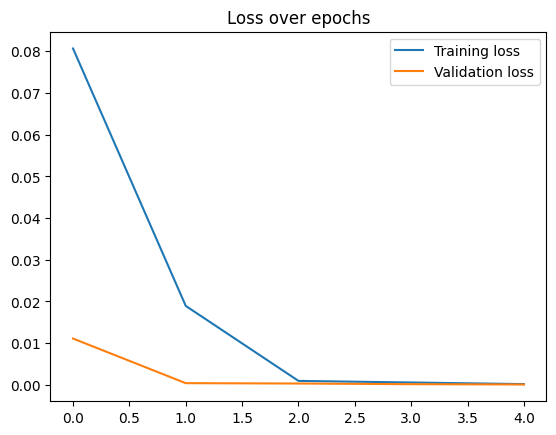

['fox', 'hedgehog']


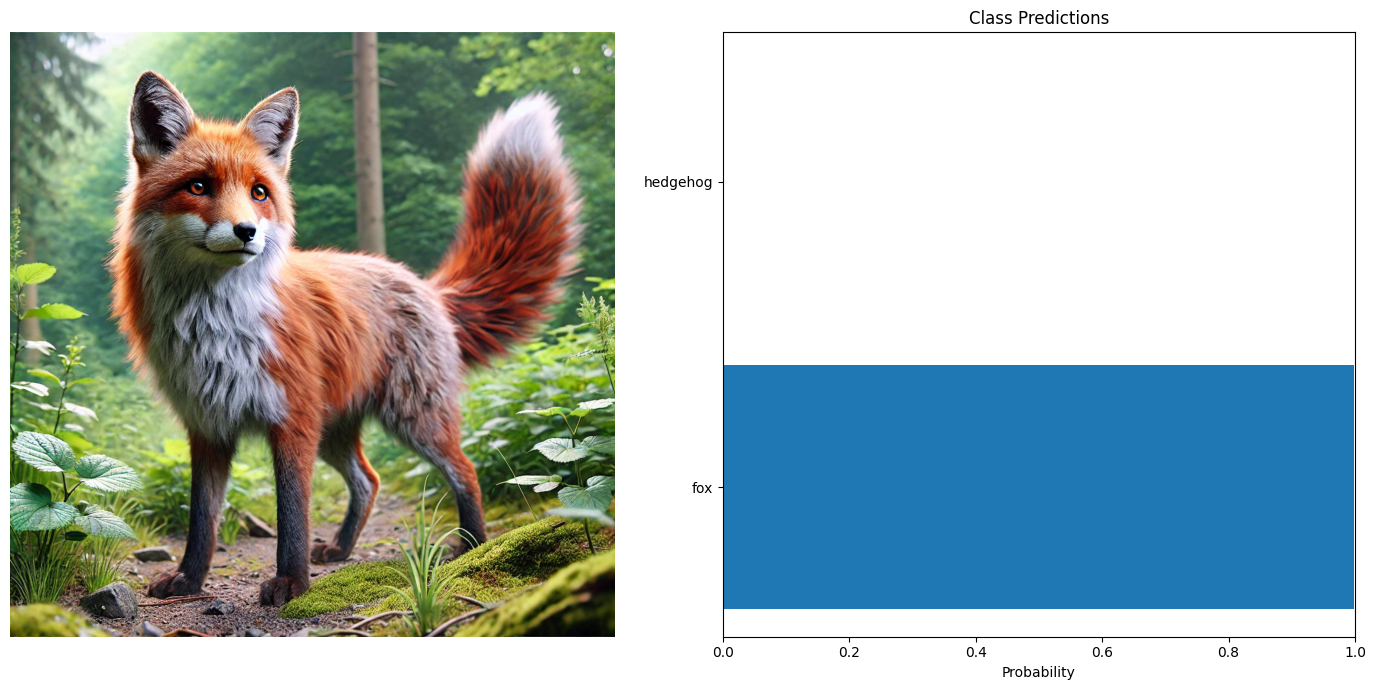

In [56]:
import torch
from timm import optim
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt

import animaldataset
import simpleclassifier
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from PIL import Image


transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

data_dir = './dataset/train'

dataset = animaldataset.AnimalDataset(data_dir, transform)

target_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_class)

model = simpleclassifier.SimpleClassifier(num_classes=2)
for image, label in dataset:
    break

dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

for images, labels in dataloader:
    break

images.shape, labels.shape

ex_output = model(images)
ex_output.shape

#optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion(ex_output, labels)

train_folder = './dataset/train'
valid_folder = './dataset/valid'

train_dataset = animaldataset.AnimalDataset(train_folder, transform=transform)
val_dataset = animaldataset.AnimalDataset(valid_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

num_epochs = 5
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = simpleclassifier.SimpleClassifier(num_classes=2)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs): 
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'): 
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'): 
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)
 
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()
 
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
 
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
 
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Fox or Hedgehog?")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()
 
test_image = "./dataset/test/fox/fox1.png"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device) 
class_names = dataset.classes 
visualize_predictions(original_image, probabilities, class_names)